In [1]:
import os
os.environ["OMP_NUM_THREADS"] = "1"
os.environ["MKL_NUM_THREADS"] = "1"
os.environ["OPENBLAS_NUM_THREADS"] = "1"
os.environ["VECLIB_MAXIMUM_THREADS"] = "1"
os.environ["NUMEXPR_NUM_THREADS"] = "1"

import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_absolute_error
from sklearn.ensemble import HistGradientBoostingRegressor

FAST_MODE = False  # flip to False for full run

data = pd.read_csv("data_melb/melb_data.csv")

if FAST_MODE:
    data = data.sample(n=10000, random_state=42)  # try 1000–3000

# 🏘️ Cross-Validated Hyperparameter Tuning for Melbourne Housing Prices

## 📌 Purpose of this Notebook

This notebook demonstrates a complete **applied machine learning workflow** for tuning a predictive model on structured (tabular) data. Using the *Melbourne Housing Snapshot* dataset from Kaggle, our goal is not just to train a model, but to show how to:

- build a **reproducible preprocessing + modeling pipeline**,
- use **cross-validation** to obtain reliable performance estimates, and
- apply **systematic hyperparameter search** to improve model quality.

The emphasis is on **process and methodology**, not just raw performance.

---

## 🧠 Overall Philosophy

In real-world ML projects, model accuracy is only one piece of the puzzle. Equally important are:

- **Data leakage avoidance** – all preprocessing must be learned only from training data.
- **Reproducibility** – results should be repeatable end-to-end.
- **Fair evaluation** – performance should reflect how the model will behave on unseen data.
- **Iterative refinement** – start simple, then progressively tune and analyze.

This notebook adopts a philosophy of:

> **“Treat preprocessing and modeling as a single object, and evaluate it as it will be used in practice.”**

That is why we use `scikit-learn` Pipelines and cross-validation throughout.

---

## 🧭 Strategy and Workflow

The notebook follows these steps from top to bottom:

### 1️⃣ Data Ingestion and Setup
We load the Melbourne housing dataset and separate:
- features `X` (house attributes), and
- target `y` (house price).

Because prices are highly skewed, we model:

\[
y = \log(\text{Price})
\]

which stabilizes variance and often improves regression performance.

---

### 2️⃣ Hold-Out Test Split
Before any tuning, we set aside a **final test set**.
This data is *never* seen during model selection and is used only once at the end for an unbiased performance estimate.

---

### 3️⃣ Preprocessing Pipeline
We define a preprocessing strategy that mirrors realistic data handling:

- **Numeric features** → median imputation for missing values.
- **Categorical features** → most-frequent imputation + one-hot encoding.

These steps are combined with a regression model into a single `Pipeline`, ensuring that:

✔ preprocessing is learned only from training folds
✔ no information leaks into validation data
✔ the workflow is fully reproducible

---

### 4️⃣ Model Choice
We use a **Histogram-based Gradient Boosting Regressor**, a strong and efficient model for tabular data that captures nonlinearities and feature interactions with minimal feature engineering.

---

### 5️⃣ Cross-Validated Hyperparameter Tuning
Instead of hand-picking model settings, we use:

- `RandomizedSearchCV`
- multiple hyperparameters (depth, learning rate, iterations, regularization, etc.)
- **k-fold cross-validation**

This yields:
- a robust estimate of performance, and
- a principled way to search for better configurations.

Performance is measured using **Mean Absolute Error (MAE)** in log-space during tuning.

---

### 6️⃣ Final Evaluation in Real Units
After selecting the best model via CV:
- predictions are transformed back with `exp`, and
- MAE is computed in **dollar units**, giving an interpretable measure of error.

This mimics how the model would be judged in practice.

---

### 7️⃣ Diagnostics and Visualization
Finally, we inspect:
- cross-validation results, and
- how performance varies with key hyperparameters,

to understand *why* certain settings work better and to guide future tuning rounds.

---

## ⚡ Fast Mode vs. Full Mode

To make iteration practical on a laptop, the notebook supports a **FAST_MODE** option that:
- samples a subset of the data, and
- uses a very small CV search.

This allows quick end-to-end testing of the workflow.
Once everything is validated, FAST_MODE can be turned off for a full, more expensive run.

This reflects a common applied ML strategy:

> **Prototype fast → validate logic → scale up carefully.**

---

## 🎯 Takeaway

By the end of this notebook, you should see how to:

✔ structure an end-to-end ML experiment
✔ tune models in a statistically sound way
✔ avoid common pitfalls like leakage
✔ balance rigor with computational cost

The result is not just a tuned model for Melbourne housing prices, but a **general template** for applied machine learning on tabular datasets.

In [2]:
if FAST_MODE:
    n_iter = 6
    cv = 5
else:
    n_iter = 20
    cv = 5

In [3]:
# Define features and target
y = data["Price"]
X = data.drop(columns=["Price"])

# Apply log transformation to the target variable to reduce skewness
y_log = np.log(y)

In [4]:
# Split data into training and testing sets
# Using an 80-20 split
X_train, X_test, y_train, y_test = train_test_split(
    X, y_log, test_size=0.2, random_state=42
)

In [5]:
# Preprocessing pipelines for both numeric and categorical data
categorical_cols = [c for c in X_train.columns if X_train[c].dtype == "object"]
numeric_cols = [c for c in X_train.columns if X_train[c].dtype != "object"]

# Preprocessing for numeric data
# Using median imputation for numeric features
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median"))
])

# Preprocessing for categorical data
# Using most frequent imputation and one-hot encoding for categorical features
categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
])

# Bundle preprocessing for numeric and categorical data
# Dropping any remaining columns that are not specified
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_cols),
        ("cat", categorical_transformer, categorical_cols),
    ],
    remainder="drop"
)

In [6]:
# Define the model
# Using HistGradientBoostingRegressor for better performance on large datasets
model = HistGradientBoostingRegressor(random_state=42)

# Create the pipeline
pipe = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("model", model)
])

In [7]:
# Hyperparameter tuning for HistGradientBoostingRegressor
#param_distributions = {
#    "model__max_depth": [3, 5, 7, 9, None],
#    "model__learning_rate": [0.01, 0.03, 0.05, 0.1, 0.2],
#    "model__max_iter": [200, 400, 800, 1200],
#    "model__min_samples_leaf": [10, 20, 50, 100],
#    "model__l2_regularization": [0.0, 0.1, 0.5, 1.0],
#    "model__max_bins": [128, 255],
#}

# Round 2: Refined hyperparameter grid based on initial results
param_distributions = {
    "model__learning_rate": [0.02, 0.04, 0.06, 0.08, 0.1],
    "model__max_iter": [300, 500, 700, 900],
    "model__max_depth": [5, 7, 9, None],
    "model__min_samples_leaf": [20, 50, 100],
    "model__l2_regularization": [0.0, 0.1, 0.5],
}

In [8]:
# Perform Randomized Search Cross-Validation

# Using neg_mean_absolute_error as the scoring metric
# 40 iterations with 5-fold cross-validation
# Using all available CPU cores for parallel processing
# Setting random_state for reproducibility
# Verbose output for monitoring progress
search = RandomizedSearchCV(
    estimator=pipe,
    param_distributions=param_distributions,
    n_iter=n_iter,
    scoring="neg_mean_absolute_error",
    cv=cv,
    random_state=42,
    n_jobs=8,
    verbose=1
)

search.fit(X_train, y_train)

search.best_params_, -search.best_score_

Fitting 5 folds for each of 20 candidates, totalling 100 fits


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


({'model__min_samples_leaf': 50,
  'model__max_iter': 900,
  'model__max_depth': None,
  'model__learning_rate': 0.08,
  'model__l2_regularization': 0.1},
 0.12863771732622523)

In [15]:
# Evaluate the best model on the test set
best_model = search.best_estimator_

# Make predictions on the test set
pred_log = best_model.predict(X_test)

# Inverse the log transformation to get predictions in original scale
pred = np.exp(pred_log)
actual = np.exp(y_test)

# Calculate Mean Absolute Error in dollars
mae_dollars = mean_absolute_error(actual, pred)
mae_dollars

147082.45454848732

In [16]:
#
results = pd.DataFrame(search.cv_results_)
cols = ["mean_test_score", "std_test_score", "rank_test_score", "params"]
results[cols].sort_values("rank_test_score").head(10)

,mean_test_score,std_test_score,rank_test_score,params
14,-0.128638,0.002702,1,"{'model__min_samples_leaf': 50, 'model__max_it..."
10,-0.128954,0.002904,2,"{'model__min_samples_leaf': 50, 'model__max_it..."
11,-0.130143,0.002898,3,"{'model__min_samples_leaf': 50, 'model__max_it..."
15,-0.131002,0.002711,4,"{'model__min_samples_leaf': 50, 'model__max_it..."
19,-0.131836,0.002635,5,"{'model__min_samples_leaf': 20, 'model__max_it..."
4,-0.131977,0.002543,6,"{'model__min_samples_leaf': 20, 'model__max_it..."
3,-0.132861,0.001926,7,"{'model__min_samples_leaf': 20, 'model__max_it..."
9,-0.133677,0.002012,8,"{'model__min_samples_leaf': 20, 'model__max_it..."
6,-0.135375,0.002836,9,"{'model__min_samples_leaf': 20, 'model__max_it..."
17,-0.135422,0.002651,10,"{'model__min_samples_leaf': 20, 'model__max_it..."


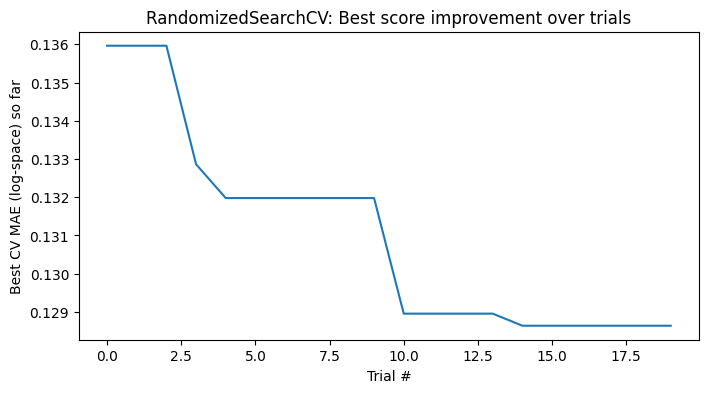

In [17]:
# Visualize the improvement of the best score over trials
# Did I run enough iterations/trials?
import pandas as pd
import matplotlib.pyplot as plt

results = pd.DataFrame(search.cv_results_)
# Convert to positive MAE (in log-space) for readability
results["mae_log"] = -results["mean_test_score"]

best_so_far = results["mae_log"].cummin()

plt.figure(figsize=(8,4))
plt.plot(best_so_far.values)
plt.xlabel("Trial #")
plt.ylabel("Best CV MAE (log-space) so far")
plt.title("RandomizedSearchCV: Best score improvement over trials")
plt.show()

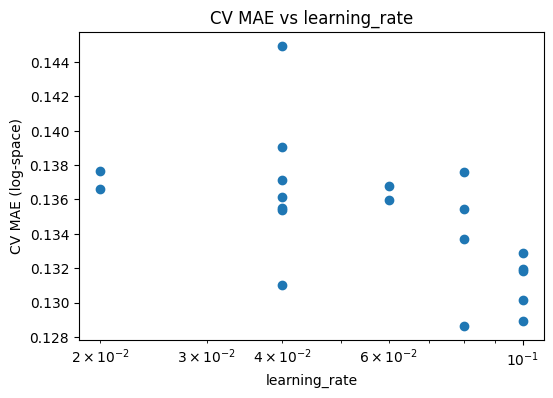

In [18]:
# Visualize the effect of learning_rate on CV MAE
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

results = pd.DataFrame(search.cv_results_)
results["mae_log"] = -results["mean_test_score"]
lr = results["param_model__learning_rate"].astype(float)

plt.figure(figsize=(6,4))
plt.scatter(lr, results["mae_log"])
plt.xlabel("learning_rate")
plt.ylabel("CV MAE (log-space)")
plt.title("CV MAE vs learning_rate")
plt.xscale("log")
plt.show()

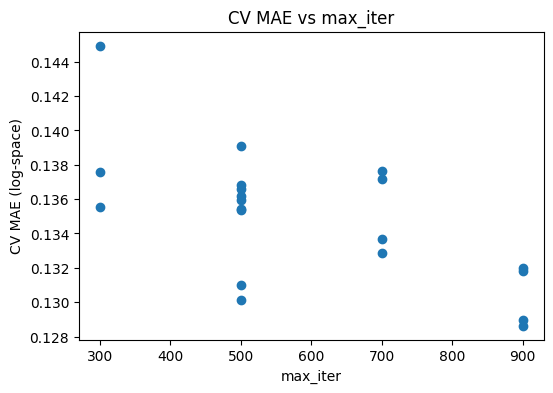

In [19]:
# Visualize the effect of max_iter on CV MAE
import pandas as pd
import matplotlib.pyplot as plt

results = pd.DataFrame(search.cv_results_)
results["mae_log"] = -results["mean_test_score"]
mi = results["param_model__max_iter"].astype(int)

plt.figure(figsize=(6,4))
plt.scatter(mi, results["mae_log"])
plt.xlabel("max_iter")
plt.ylabel("CV MAE (log-space)")
plt.title("CV MAE vs max_iter")
plt.show()

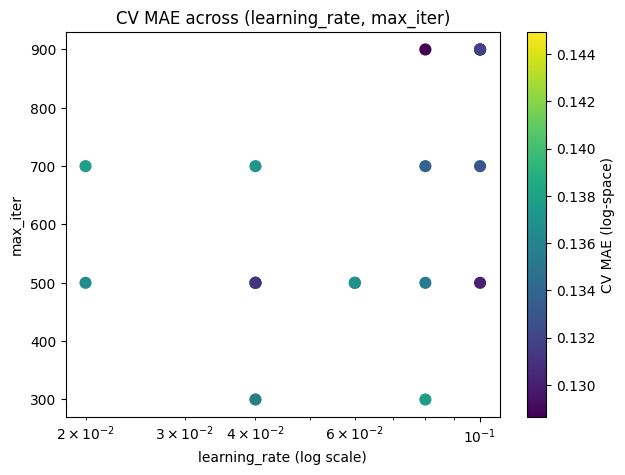

In [20]:
# Plot: Interaction view (learning_rate vs max_iter)
# This often reveals the “more trees + smaller LR” tradeoff.

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

results = pd.DataFrame(search.cv_results_)
results["mae_log"] = -results["mean_test_score"]

lr = results["param_model__learning_rate"].astype(float)
mi = results["param_model__max_iter"].astype(int)

plt.figure(figsize=(7,5))
plt.scatter(lr, mi, s=60, c=results["mae_log"])
plt.xscale("log")
plt.xlabel("learning_rate (log scale)")
plt.ylabel("max_iter")
plt.title("CV MAE across (learning_rate, max_iter)")
plt.colorbar(label="CV MAE (log-space)")
plt.show()

In [21]:
# lock in the best model from round 2 and evaluate on test set
best_model = search.best_estimator_

pred_log = best_model.predict(X_test)
pred = np.exp(pred_log)
actual = np.exp(y_test)

from sklearn.metrics import mean_absolute_error
mae_test = mean_absolute_error(actual, pred)
mae_test

147082.45454848732

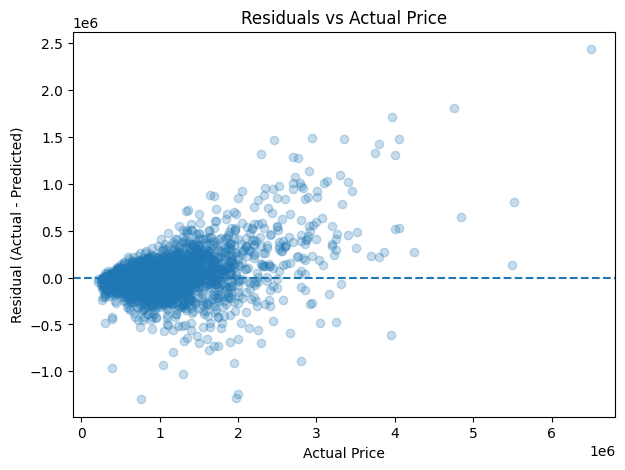

In [22]:
# Plot residuals vs actual prices
import matplotlib.pyplot as plt

residual = actual - pred

plt.figure(figsize=(7,5))
plt.scatter(actual, residual, alpha=0.25)
plt.axhline(0, linestyle="--")
plt.xlabel("Actual Price")
plt.ylabel("Residual (Actual - Predicted)")
plt.title("Residuals vs Actual Price")
plt.show()

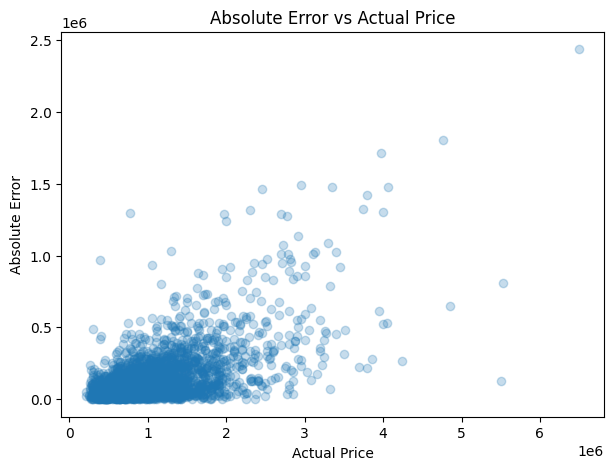

In [23]:
#
abs_err = (actual - pred).abs()

plt.figure(figsize=(7,5))
plt.scatter(actual, abs_err, alpha=0.25)
plt.xlabel("Actual Price")
plt.ylabel("Absolute Error")
plt.title("Absolute Error vs Actual Price")
plt.show()

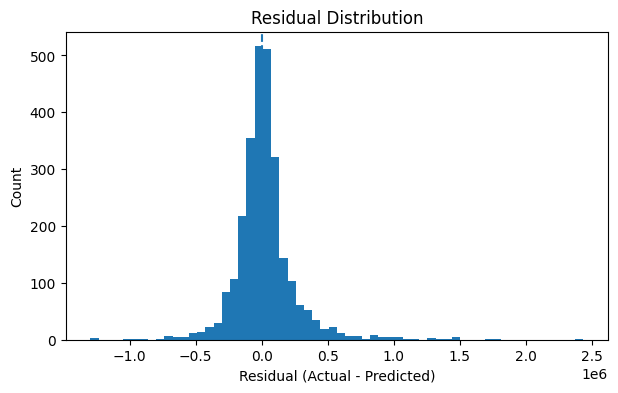

In [25]:
# Plot histogram of residuals
plt.figure(figsize=(7,4))
plt.hist(residual, bins=60)
plt.axvline(0, linestyle="--")
plt.xlabel("Residual (Actual - Predicted)")
plt.ylabel("Count")
plt.title("Residual Distribution")
plt.show()

In [26]:
if "Type" in X_test.columns:
    df_err = pd.DataFrame({"Actual": actual, "Pred": pred})
    df_err["AbsError"] = (df_err["Actual"] - df_err["Pred"]).abs()
    df_err["Type"] = X_test["Type"].values

    df_err.groupby("Type")["AbsError"].agg(["count","mean","median"]).sort_values("mean", ascending=False)

In [27]:
if "Suburb" in X_test.columns:
    df_err = pd.DataFrame({"AbsError": abs_err, "Suburb": X_test["Suburb"].values})
    suburb_stats = df_err.groupby("Suburb")["AbsError"].agg(["count","mean","median"])
    suburb_stats = suburb_stats[suburb_stats["count"] >= 20].sort_values("mean", ascending=False)
    suburb_stats.head(15)

In [29]:
# Feature importance using permutation importance
from sklearn.inspection import permutation_importance

perm = permutation_importance(
    best_model, X_test, y_test,
    n_repeats=10,
    random_state=42,
    n_jobs=8
)

imp = pd.Series(perm.importances_mean, index=X_test.columns).sort_values(ascending=False)
imp.head(20)

Distance         0.241642
Type             0.239837
Regionname       0.158890
Landsize         0.122598
Rooms            0.073324
Lattitude        0.068891
Longtitude       0.066230
Bathroom         0.031706
BuildingArea     0.019254
YearBuilt        0.012796
Car              0.011163
Method           0.011139
Postcode         0.007717
Bedroom2         0.006711
Date             0.006654
Propertycount    0.005630
Suburb           0.005221
SellerG          0.005177
CouncilArea      0.004072
Address          0.000000
dtype: float64

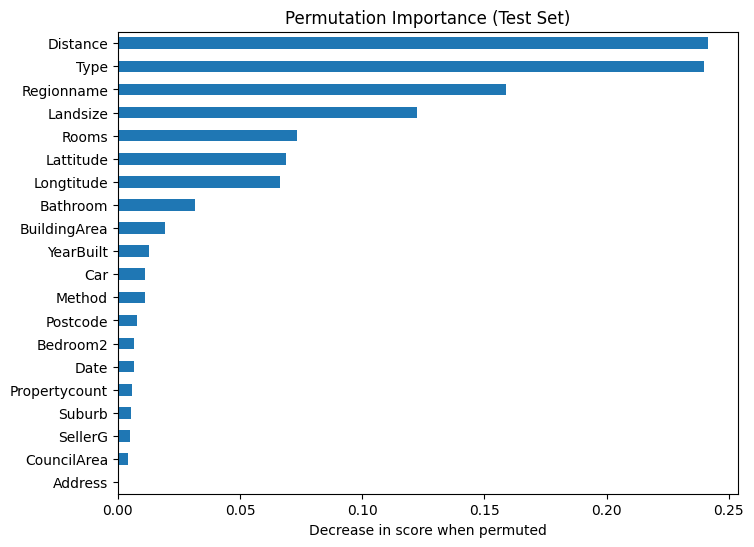

In [30]:
# Plot permutation importance
plt.figure(figsize=(8,6))
imp.head(20).sort_values().plot(kind="barh")
plt.title("Permutation Importance (Test Set)")
plt.xlabel("Decrease in score when permuted")
plt.show()

In [32]:
import joblib

joblib.dump(best_model, "melbourne_housing_model.joblib")

loaded = joblib.load("melbourne_housing_model.joblib")
loaded.predict(X_test.head())

array([14.63333441, 13.3234831 , 13.61905893, 13.18669732, 13.60626263])

/var/folders/5f/rgfnh64x7k1bfzln9qq9n76r0000gr/T/ipykernel_50389/1615751834.py:19: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(data, labels=top_cats, showfliers=False)
/var/folders/5f/rgfnh64x7k1bfzln9qq9n76r0000gr/T/ipykernel_50389/1615751834.py:19: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(data, labels=top_cats, showfliers=False)
/var/folders/5f/rgfnh64x7k1bfzln9qq9n76r0000gr/T/ipykernel_50389/1615751834.py:19: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(data, labels=top_cats, showfliers=False)


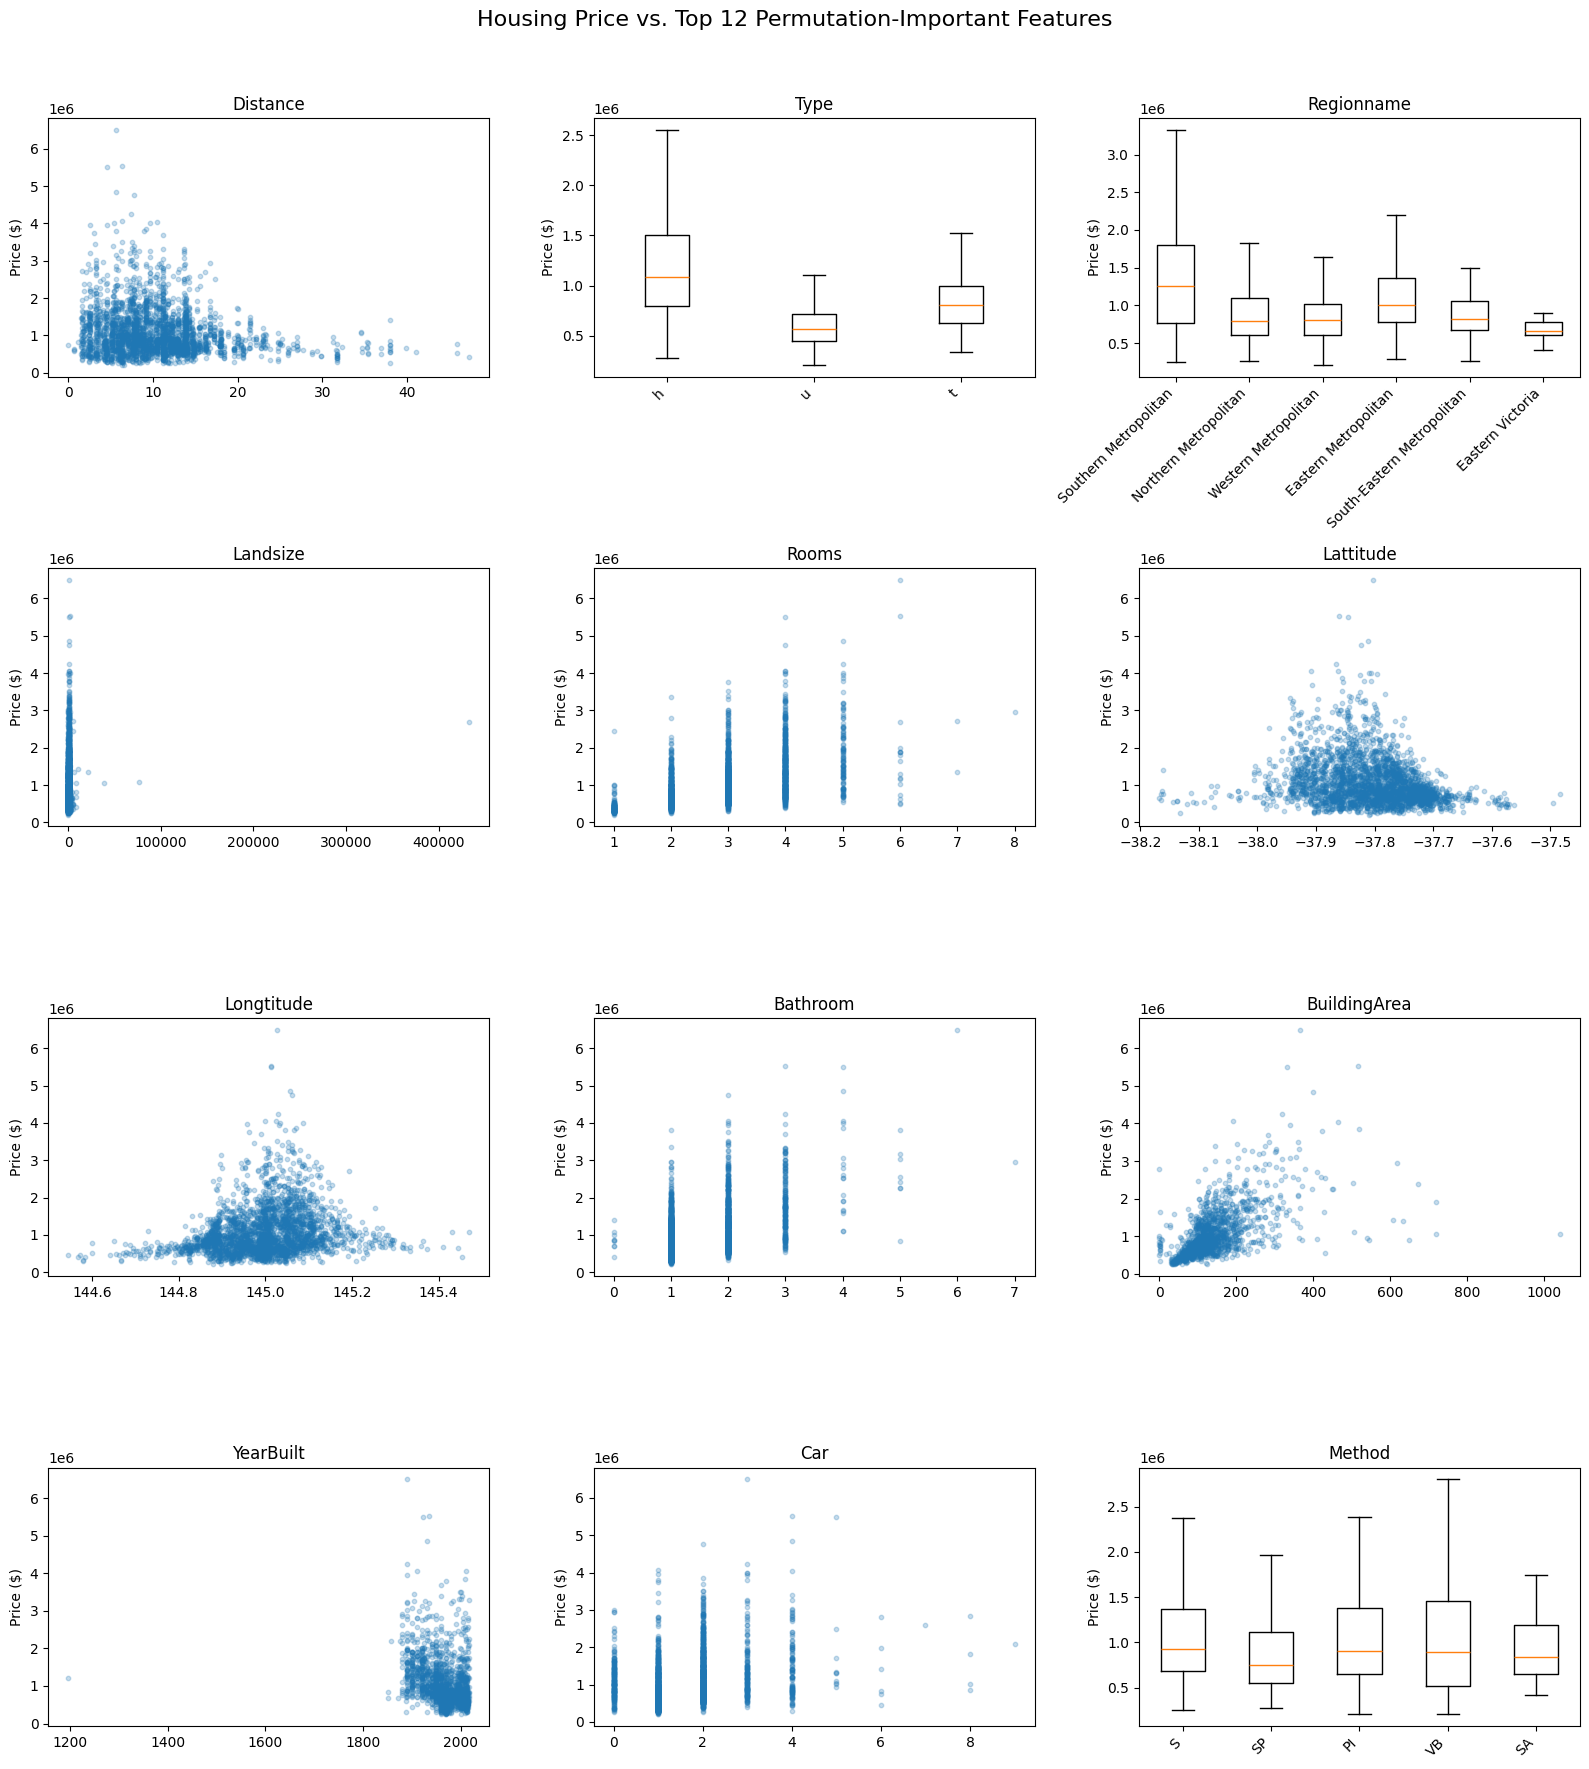

In [33]:
import matplotlib.pyplot as plt
import numpy as np

top_features = imp.head(12).index

fig, axes = plt.subplots(4, 3, figsize=(16, 18))
axes = axes.flatten()

for ax, feat in zip(axes, top_features):
    if X_test[feat].dtype == "object":
        # For categorical features: boxplot of top categories
        top_cats = X_test[feat].value_counts().head(6).index
        mask = X_test[feat].isin(top_cats)

        data = [
            actual[mask & (X_test[feat] == cat)]
            for cat in top_cats
        ]
        ax.boxplot(data, labels=top_cats, showfliers=False)
        ax.set_xticklabels(top_cats, rotation=45, ha="right")
    else:
        # For numeric features: scatter plot
        ax.scatter(X_test[feat], actual, alpha=0.25, s=10)

    ax.set_title(feat)
    ax.set_ylabel("Price ($)")

# Hide any unused subplots
for ax in axes[len(top_features):]:
    ax.axis("off")

fig.suptitle("Housing Price vs. Top 12 Permutation-Important Features", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

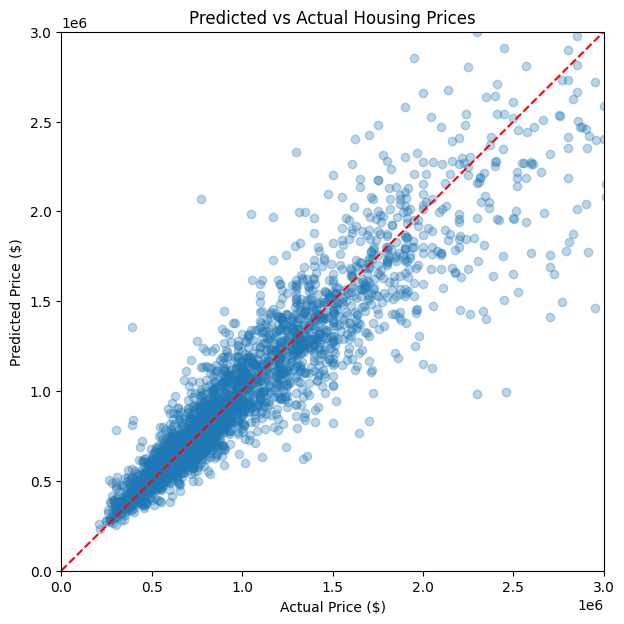

In [34]:
# create a plot of predicted vs actual prices
import matplotlib.pyplot as plt
plt.figure(figsize=(7,7))
plt.scatter(actual, pred, alpha=0.3)
plt.plot([0, 3000000], [0, 3000000], color="red", linestyle="--")
plt.xlabel("Actual Price ($)")
plt.ylabel("Predicted Price ($)")
plt.title("Predicted vs Actual Housing Prices")
plt.xlim(0, 3000000)
plt.ylim(0, 3000000)
plt.show()

In [35]:
# now, let's compare this to a model where we choose the hyperparameters by hand
# let's choose features = ['Rooms', 'Bathroom', 'Landsize', 'BuildingArea', 'YearBuilt']

features = ['Rooms', 'Bathroom', 'Landsize', 'BuildingArea', 'YearBuilt']
X_train_simple = X_train[features]
X_test_simple = X_test[features]
pipe_simple = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("model", HistGradientBoostingRegressor(
        max_depth=7,
        learning_rate=0.05,
        max_iter=800,
        min_samples_leaf=50,
        l2_regularization=0.1,
        random_state=42
    ))
])

pipe_simple.fit(X_train_simple, y_train)
pred_log_simple = pipe_simple.predict(X_test_simple)
pred_simple = np.exp(pred_log_simple)

mae_simple = mean_absolute_error(actual, pred_simple)
mae_simple

296662.48110474384

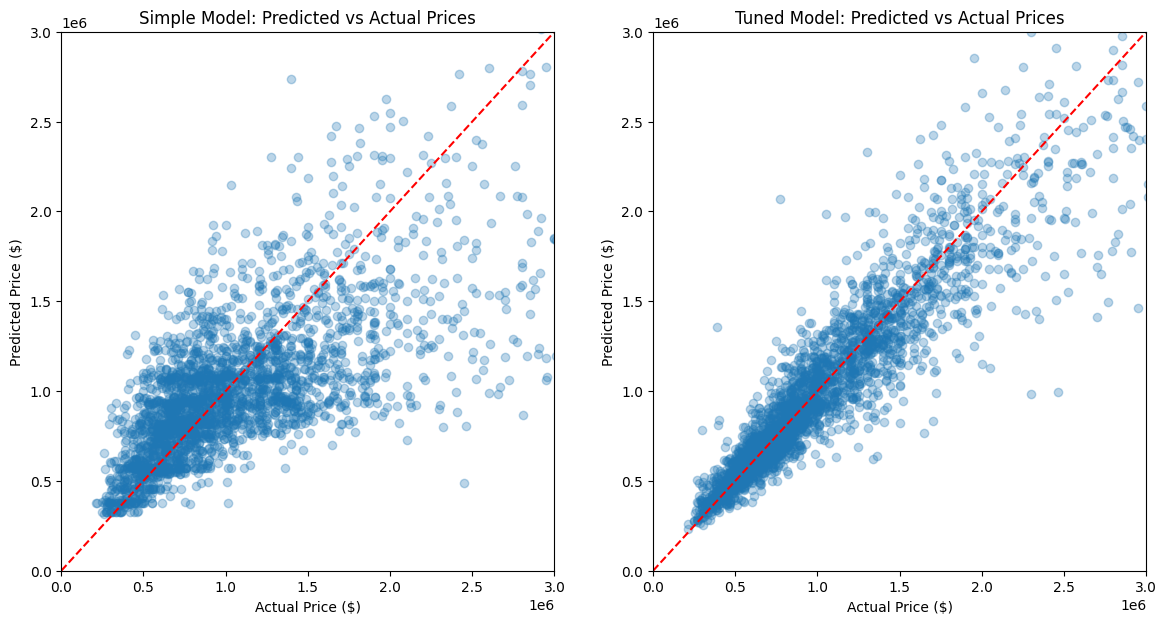

In [37]:
# create a plot of predicted vs actual prices for the simple model and for the better model, and compare
# them side by side
import matplotlib.pyplot as plt
plt.figure(figsize=(14,7))
plt.subplot(1, 2, 1)
plt.scatter(actual, pred_simple, alpha=0.3)
plt.plot([0, 3000000], [0, 3000000], color="red", linestyle="--")
plt.xlabel("Actual Price ($)")
plt.ylabel("Predicted Price ($)")
plt.title("Simple Model: Predicted vs Actual Prices")
plt.xlim(0, 3000000)
plt.ylim(0, 3000000)
plt.subplot(1, 2, 2)
plt.scatter(actual, pred, alpha=0.3)
plt.plot([0, 3000000], [0, 3000000], color="red", linestyle="--")
plt.xlabel("Actual Price ($)")
plt.ylabel("Predicted Price ($)")
plt.title("Tuned Model: Predicted vs Actual Prices")
plt.xlim(0, 3000000)
plt.ylim(0, 3000000)
plt.show()
